In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

from skimage.feature import hog
from matplotlib.figure import figaspect
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from collections import deque

%matplotlib inline

In [2]:
# A Detector used to detect cars
class Detector():
    def __init__(self, threshold, n, image):
        # Queue to cache windows in last n frames
        self.que = deque(maxlen=n)
        # heatmap shape
        self.shape = (image.shape[0], image.shape[1])
        # heatmap threshold for n frames
        self.threshold = threshold
        # cache size
        self.n = n
        
    def detect(self, hot_windows):
        heatmap = np.zeros(self.shape).astype(float)
        self.que.append(hot_windows)
        for boxes in self.que:
            for box in boxes:
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
        heatmap[heatmap <= self.threshold] = 0 
        return label(heatmap)

    def draw_debug(self, draw_img):
        count = 0
        imcopy = np.copy(draw_image)
        for boxes in self.que:
            count += len(boxes)
            imcopy = draw_boxes(imcopy, boxes)
        return imcopy, count
    
def countHelper(count):
    if count < 10:
        return "000" + str(count)
    elif count < 100:
        return "00" + str(count)
    elif count < 1000:
        return "0" + str(count)
    else:
        return str(count)
    
def write_image(filename, image):
    cv2.imwrite(filename + ".jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Step 1. HOG and feature extraction

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

(720, 1280, 3)


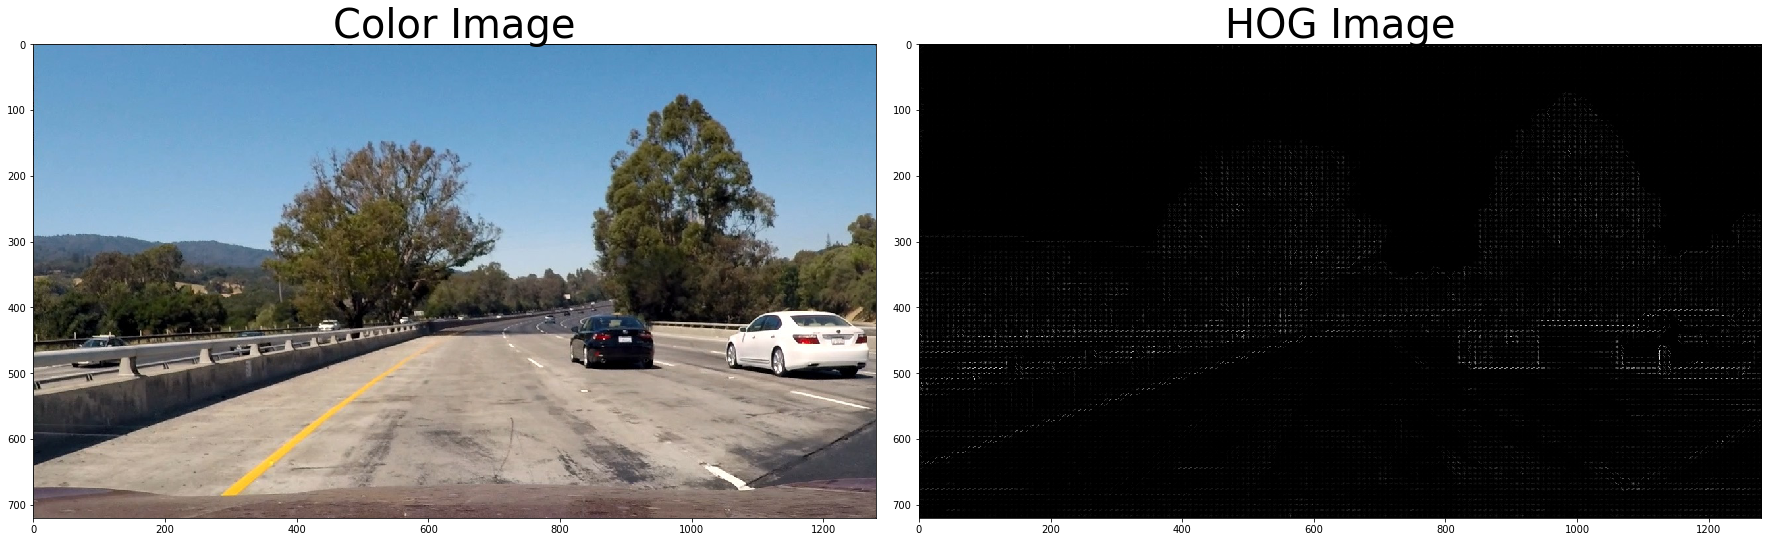

In [4]:
images = glob.glob('./test_images/test*')

img = mpimg.imread(images[0])
print(img.shape)
ycrcb_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)


orient = 9
pixels_per_cell = 8
cells_per_block = 2
    
features, hogimg = get_hog_features(ycrcb_img[:,:,0], orient, pixels_per_cell, cells_per_block,
                                    vis=True, feature_vec=False)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Color Image', fontsize=40)

ax2.imshow(hogimg, cmap='gray')
ax2.set_title('HOG Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("./output_images/hog.jpg")

## Step 2. Train a classifier

In [5]:
def training(cars, notcars) :
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float32)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print(X_train.shape)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
             
    return X_scaler, svc

## Step 3. Sliding Window Search

In [6]:
# Define a single function that can extract features using hog sub-sampling and 
# make predictions, returns the hot_windows
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):    
    windows = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                
    return windows

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [7]:
############# Parameters #############
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in for small, median, large windows
scales = 1.5 # scale for small, median, large windows
heatmap_threshold = 10
cache_size = 10


############# Training #############

#Read the traing images
cars = glob.glob('./vehicles/*/*')
notcars = glob.glob('./non-vehicles/*/*')
print('Car images', len(cars))
print('Not car images: ',len(notcars))
# Train
X_scaler, svc = training(cars, notcars)


############# Tracking Pipeline #############
plt.ioff()
vidcap = cv2.VideoCapture('./test_video.mp4')
success,image = vidcap.read()

count = 0
success = True
detector = Detector(heatmap_threshold, cache_size, image)
while success:
    print('Read a new frame: ', str(count), ', ', success)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255

    hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1], scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    labels = detector.detect(hot_windows)    
    window_img = draw_labeled_bboxes(draw_image, labels)

    filename = "./output_images/result_test/image" + countHelper(count)
    write_image(filename, window_img)

    count += 1
    success,image = vidcap.read()

print("Succeed")

Car images 8792
Not car images:  8968
(14208, 6108)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
14.1 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
Read a new frame:  0 ,  True
Read a new frame:  1 ,  True
Read a new frame:  2 ,  True
Read a new frame:  3 ,  True
Read a new frame:  4 ,  True
Read a new frame:  5 ,  True
Read a new frame:  6 ,  True
Read a new frame:  7 ,  True
Read a new frame:  8 ,  True
Read a new frame:  9 ,  True
Read a new frame:  10 ,  True
Read a new frame:  11 ,  True
Read a new frame:  12 ,  True
Read a new frame:  13 ,  True
Read a new frame:  14 ,  True
Read a new frame:  15 ,  True
Read a new frame:  16 ,  True
Read a new frame:  17 ,  True
Read a new frame:  18 ,  True
Read a new frame:  19 ,  True
Read a new frame:  20 ,  True
Read a new frame:  21 ,  True
Read a new frame:  22 ,  True
Read a new frame:  23 ,  True
Read a new frame:  24 ,  True
Read a new frame:  25 ,  True
Read a new frame:  26 ,  Tru

In [8]:
############# Tracking Pipeline #############
# plt.ioff()
# vidcap = cv2.VideoCapture('./test_video.mp4')
# success,image = vidcap.read()

# count = 0
# success = True
# detector = Detector(heatmap_threshold, cache_size, image)
# while success:
#     print('Read a new frame: ', str(count), ', ', success)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     draw_image = np.copy(image)
#     image = image.astype(np.float32)/255

#     hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1], scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     labels = detector.detect(hot_windows)
#     window_img, total = detector.draw_debug(draw_image)
    
# #     window_img = draw_labeled_bboxes(draw_image, labels)
# #     window_img = draw_boxes(draw_image, hot_windows)
# #     window_img = detection(draw_image, hot_windows, heatmap_single_threshold)
    
#     filename = "./output_images/result_test/image" + countHelper(count)
# #     write_image(filename, window_img)

# #     plt.imshow(heatmap, cmap='hot')
# #     plt.savefig(filename)
# #     plt.close()

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#     f.tight_layout()

#     ax1.imshow(window_img)
#     ax1.set_title('Origin Image', fontsize=40)

#     ax2.imshow(labels[0], cmap='gray')
#     ax2.set_title('Heatmap Image', fontsize=40)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#     f.savefig(filename)


#     count += 1
#     success,image = vidcap.read()

# print("Succeed")

In [10]:
plt.ioff()
vidcap = cv2.VideoCapture('./test_video.mp4')
success,image = vidcap.read()

heatmap_threshold = 3
count = 0
success = True
detector = Detector(heatmap_threshold, cache_size, image)
while success:
    print('Read a new frame: ', str(count), ', ', success)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255

    hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1], scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    labels = detector.detect(hot_windows)    
    window_img = draw_labeled_bboxes(draw_image, labels)

    filename = "./output_images/result_test/image" + countHelper(count)
    write_image(filename, window_img)

    count += 1
    success,image = vidcap.read()

print("Succeed")

Read a new frame:  0 ,  True
Read a new frame:  1 ,  True
Read a new frame:  2 ,  True
Read a new frame:  3 ,  True
Read a new frame:  4 ,  True
Read a new frame:  5 ,  True
Read a new frame:  6 ,  True
Read a new frame:  7 ,  True
Read a new frame:  8 ,  True
Read a new frame:  9 ,  True
Read a new frame:  10 ,  True
Read a new frame:  11 ,  True
Read a new frame:  12 ,  True
Read a new frame:  13 ,  True
Read a new frame:  14 ,  True
Read a new frame:  15 ,  True
Read a new frame:  16 ,  True
Read a new frame:  17 ,  True
Read a new frame:  18 ,  True
Read a new frame:  19 ,  True
Read a new frame:  20 ,  True
Read a new frame:  21 ,  True
Read a new frame:  22 ,  True
Read a new frame:  23 ,  True
Read a new frame:  24 ,  True
Read a new frame:  25 ,  True
Read a new frame:  26 ,  True
Read a new frame:  27 ,  True
Read a new frame:  28 ,  True
Read a new frame:  29 ,  True
Read a new frame:  30 ,  True
Read a new frame:  31 ,  True
Read a new frame:  32 ,  True
Read a new frame:  3